# Import Required Libraries

In [183]:
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import numpy as np

# used for data augmentation
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# the base model for transfer learning
from tensorflow.keras.applications import MobileNetV2

# building classification on top of the CNN
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

# building the optimizer
from tensorflow.keras.optimizers import Adam

# used to evaluate the performance of the model
from sklearn.metrics import classification_report, confusion_matrix

# used for displaying images
from IPython.display import display
from PIL import Image

# Set Parameters and Data Preparation


In [185]:
AUTO = tf.data.AUTOTUNE  # Used to dynamically adjust parallelism.
BATCH_SIZE = 64

# Comes from Table 4 and "Training setup" section.
TEMPERATURE = 10  # Used to soften the logits before they go to softmax.
INIT_LR = 0.003  # Initial learning rate that will be decayed over the training period.
WEIGHT_DECAY = 0.001  # Used for regularization.
CLIP_THRESHOLD = 1.0  # Used for clipping the gradients by L2-norm.

# We will first resize the training images to a bigger size and then we will take
# random crops of a lower size.
BIGGER = 256
RESIZE = 224

In [186]:
# common size of images for mobile net
img_width, img_height = 224, 224

# bath size - sets the number of imager per training steps
# epochs - number of full training cycles
batch_size = 32
epochs = 5


path_to_training_data = './augmented'


#data augmentation
train_datagen = ImageDataGenerator(
    # each pixel value is scaled to between 1 and 255
    # this helps in gradient optimization, faster training, and better efficiency with activation functions
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',

    # splitting the data into training and validation sets
    validation_split=0.2)

# reads the images from specified folder and labels them automatically based on sub-folder names
train_generator = train_datagen.flow_from_directory(
    path_to_training_data,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training')

validation_generator = train_datagen.flow_from_directory(
    path_to_training_data,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation')

def generator_to_tf_dataset(generator):
    def gen():
        for batch_images, batch_labels in generator:
            for img, label in zip(batch_images, batch_labels):  # Yield individual samples
                yield img, label

    return tf.data.Dataset.from_generator(
        gen,
        output_signature=(
            tf.TensorSpec(shape=(img_width, img_height, 3), dtype=tf.float32),  # Single image
            tf.TensorSpec(shape=(generator.num_classes,), dtype=tf.float32)  # Single label
        )
    )


# Convert generators to tf.data.Dataset
unbatched_training_data = generator_to_tf_dataset(train_generator)
unbatched_validation_data = generator_to_tf_dataset(validation_generator)

Found 4913 images belonging to 4 classes.
Found 1228 images belonging to 4 classes.


In [187]:
def mixup(images, labels):
    alpha = tf.random.uniform([], 0, 1)
    mixedup_images = alpha * images + (1 - alpha) * tf.reverse(images, axis=[0])
    # The labels do not matter here since they are NOT used during
    # training.
    return mixedup_images, labels

def preprocess_image(image, label, train=True):
    image = tf.cast(image, tf.float32) / 255.0

    if train:
        image = tf.image.resize(image, (BIGGER, BIGGER))
        image = tf.image.random_crop(image, (RESIZE, RESIZE, 3))
        image = tf.image.random_flip_left_right(image)
    else:
        # Central fraction amount is from here:
        # https://git.io/J8Kda.
        image = tf.image.central_crop(image, central_fraction=0.875)
        image = tf.image.resize(image, (RESIZE, RESIZE))

    return image, label
    
def prepare_dataset(dataset, train=True, batch_size=BATCH_SIZE):
    if train:
        dataset = dataset.map(preprocess_image, num_parallel_calls=AUTO)
        dataset = dataset.shuffle(BATCH_SIZE * 10)
    else:
        dataset = dataset.map(
            lambda x, y: (preprocess_image(x, y, train)), num_parallel_calls=AUTO
        )
    dataset = dataset.batch(batch_size)

    if train:
        dataset = dataset.map(mixup, num_parallel_calls=AUTO)

    dataset = dataset.prefetch(AUTO)
    return dataset

In [188]:
train_ds = prepare_dataset(unbatched_training_data, True)
validation_ds = prepare_dataset(unbatched_validation_data, False)
test_ds = prepare_dataset(unbatched_validation_data, False)

for images, labels, in train_ds.take(1):
    print(labels.shape)

(64, 4)


2025-03-17 18:41:15.629182: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


# Model

In [190]:
def build_model():
    # loads the base model MobileNetV2 with pre-trained weights without the top classification
    # layer. "include_top=False"
    base_model = MobileNetV2(weights='imagenet', include_top=False,
                                  input_shape=(img_width, img_height, 3))

    # freezing the pre-trained layers from being updated during the intital training phase
    base_model.trainable = False


    x = base_model.output

    # reduces the spatial dimensions of the feature maps
    x = GlobalAveragePooling2D()(x)

    # adding a dense layer with 'relu' activation and 1024 neurons
    x = Dense(1024, activation='relu')(x)

    # final dense layer with softmax activation is used to give probablities for each classes
    predictions = Dense(train_generator.num_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)

    # The model is compiled with the Adam optimizer (with a low learning rate),
    # using categorical crossentropy as the loss function, and accuracy as the performance metric.
    model.compile(optimizer=Adam(learning_rate=0.0001),
                  loss='categorical_crossentropy', metrics=['accuracy'])
    return model

model = build_model()

# Model Training Before Transfer Learning

In [192]:
# model is trained and evaluated

history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator)

initial_test_loss, initial_test_acc = model.evaluate(validation_generator, steps=validation_generator.samples // batch_size)
print(f"Test Accuracy Before Fine-tuning: {initial_test_acc*100:.2f}%")

Epoch 1/5
154/154 ━━━━━━━━━━━━━━━━━━━━ 28s 163ms/step - accuracy: 0.6371 - loss: 0.8083 - val_accuracy: 0.7980 - val_loss: 0.4508
Epoch 2/5
154/154 ━━━━━━━━━━━━━━━━━━━━ 23s 147ms/step - accuracy: 0.7773 - loss: 0.4813 - val_accuracy: 0.8103 - val_loss: 0.4298
Epoch 3/5
154/154 ━━━━━━━━━━━━━━━━━━━━ 22s 146ms/step - accuracy: 0.7841 - loss: 0.4577 - val_accuracy: 0.8021 - val_loss: 0.4395
Epoch 4/5
154/154 ━━━━━━━━━━━━━━━━━━━━ 23s 148ms/step - accuracy: 0.8022 - loss: 0.4424 - val_accuracy: 0.8339 - val_loss: 0.3935
Epoch 5/5
154/154 ━━━━━━━━━━━━━━━━━━━━ 23s 149ms/step - accuracy: 0.8028 - loss: 0.4261 - val_accuracy: 0.8168 - val_loss: 0.4237
38/38 ━━━━━━━━━━━━━━━━━━━━ 4s 116ms/step - accuracy: 0.7941 - loss: 0.4075
Test Accuracy Before Fine-tuning: 81.25%


# Plot Accuracy and Loss Before Fine-Tuning

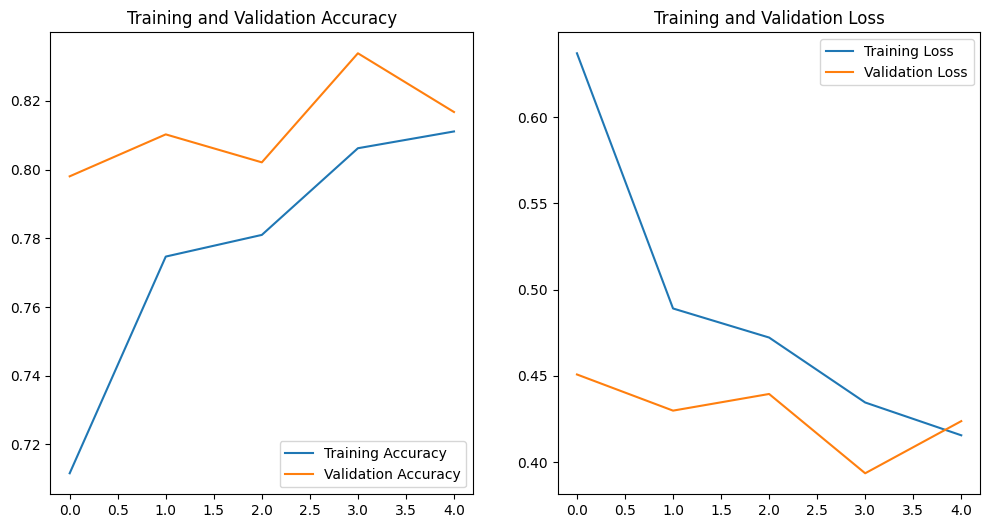

38/38 ━━━━━━━━━━━━━━━━━━━━ 4s 115ms/step - accuracy: 0.7927 - loss: 0.4605
Test Accuracy After Fine-tuning: 80.76%


In [194]:
def plot_acc_loss(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(len(acc))

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

plot_acc_loss(history)
test_loss, test_acc = model.evaluate(validation_generator, steps=validation_generator.samples // batch_size)
print(f"Test Accuracy After Fine-tuning: {test_acc*100:.2f}%")

# Fine-Tuning and Re-Training

In [196]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam


base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))


x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(4, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

model.fit(train_generator, epochs=5, validation_data=validation_generator)


Epoch 1/5
154/154 ━━━━━━━━━━━━━━━━━━━━ 29s 164ms/step - accuracy: 0.6166 - loss: 0.8395 - val_accuracy: 0.7549 - val_loss: 0.5152
Epoch 2/5
154/154 ━━━━━━━━━━━━━━━━━━━━ 23s 148ms/step - accuracy: 0.7767 - loss: 0.5072 - val_accuracy: 0.7989 - val_loss: 0.4712
Epoch 3/5
154/154 ━━━━━━━━━━━━━━━━━━━━ 22s 145ms/step - accuracy: 0.7983 - loss: 0.4731 - val_accuracy: 0.8070 - val_loss: 0.4346
Epoch 4/5
154/154 ━━━━━━━━━━━━━━━━━━━━ 23s 149ms/step - accuracy: 0.7982 - loss: 0.4486 - val_accuracy: 0.7964 - val_loss: 0.4422
Epoch 5/5
154/154 ━━━━━━━━━━━━━━━━━━━━ 23s 148ms/step - accuracy: 0.7940 - loss: 0.4358 - val_accuracy: 0.7883 - val_loss: 0.4852


# Plot Accuracy and Loss After Transfer Learning

Epoch 1/5
154/154 ━━━━━━━━━━━━━━━━━━━━ 23s 150ms/step - accuracy: 0.8150 - loss: 0.4172 - val_accuracy: 0.7956 - val_loss: 0.4487
Epoch 2/5
154/154 ━━━━━━━━━━━━━━━━━━━━ 23s 148ms/step - accuracy: 0.8131 - loss: 0.4064 - val_accuracy: 0.8217 - val_loss: 0.4222
Epoch 3/5
154/154 ━━━━━━━━━━━━━━━━━━━━ 23s 147ms/step - accuracy: 0.8100 - loss: 0.4254 - val_accuracy: 0.8127 - val_loss: 0.4356
Epoch 4/5
154/154 ━━━━━━━━━━━━━━━━━━━━ 23s 147ms/step - accuracy: 0.8212 - loss: 0.4075 - val_accuracy: 0.8103 - val_loss: 0.4390
Epoch 5/5
154/154 ━━━━━━━━━━━━━━━━━━━━ 23s 147ms/step - accuracy: 0.8121 - loss: 0.4124 - val_accuracy: 0.8208 - val_loss: 0.4189


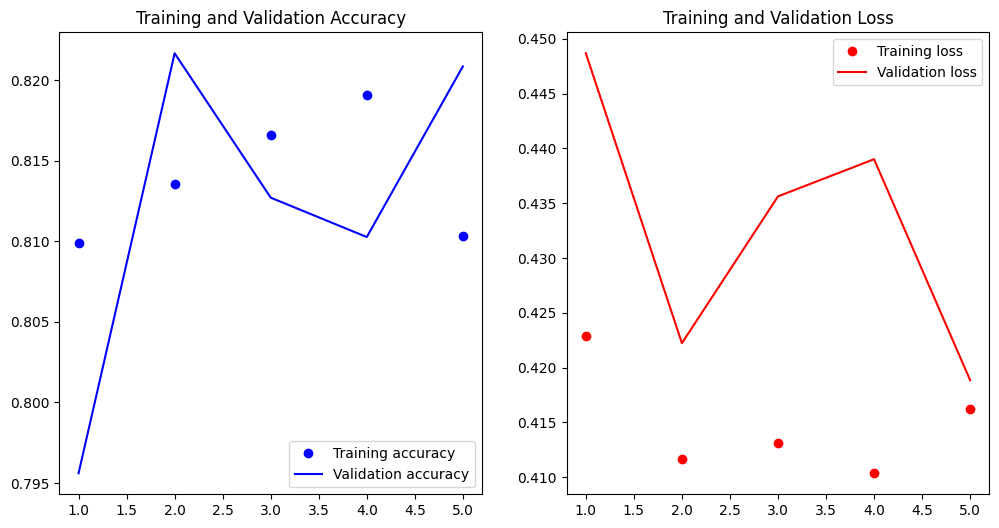

In [198]:
fine_tune_history = model.fit(
    train_generator,
    epochs=5,
    validation_data=validation_generator
)
import matplotlib.pyplot as plt

def plot_acc_loss(training_history):
    acc = training_history.history['accuracy']
    val_acc = training_history.history['val_accuracy']
    loss = training_history.history['loss']
    val_loss = training_history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'bo', label='Training accuracy')
    plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'ro', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    plt.show()


plot_acc_loss(fine_tune_history)


In [199]:
test_loss, test_acc = model.evaluate(validation_generator, steps=validation_generator.samples // batch_size)
print(f"Test Accuracy After Fine-tuning: {test_acc*100:.2f}%")

38/38 ━━━━━━━━━━━━━━━━━━━━ 4s 112ms/step - accuracy: 0.7990 - loss: 0.4743
Test Accuracy After Fine-tuning: 80.84%


# hyperparameters and constant

In [201]:
AUTO = tf.data.AUTOTUNE  # Used to dynamically adjust parallelism.
BATCH_SIZE = 64

# Comes from Table 4 and "Training setup" section.
TEMPERATURE = 10  # Used to soften the logits before they go to softmax.
INIT_LR = 0.003  # Initial learning rate that will be decayed over the training period.
WEIGHT_DECAY = 0.001  # Used for regularization.
CLIP_THRESHOLD = 1.0  # Used for clipping the gradients by L2-norm.

# We will first resize the training images to a bigger size and then we will take
# random crops of a lower size.
BIGGER = 160
RESIZE = 224


# student model

In [203]:
from tensorflow import keras

def get_resnetv2():
    resnet_v2 = keras.applications.ResNet50V2(
        weights=None,
        input_shape=(RESIZE, RESIZE, 3),
        classes=4,
        classifier_activation="linear",
    )
    return resnet_v2


get_resnetv2().count_params()

23572996

# create a distiller class 

In [255]:
class Distiller(tf.keras.Model):
    def __init__(self, student, teacher):
        super().__init__()
        self.student = student
        self.teacher = teacher
        self.loss_tracker = keras.metrics.Mean(name="distillation_loss")

    @property
    def metrics(self):
        metrics = super().metrics
        metrics.append(self.loss_tracker)
        return metrics

    def compile(
        self, optimizer, metrics, distillation_loss_fn, temperature=TEMPERATURE,
    ):
        super().compile(optimizer=optimizer, metrics=metrics)
        self.distillation_loss_fn = distillation_loss_fn
        self.temperature = temperature

    def train_step(self, data):
        # Unpack data
        x, y = data

        # Forward pass of teacher
        teacher_predictions = self.teacher(x, training=False)
        
        if len(y.shape) == 1 or y.shape[-1] == 1:
            y = tf.one_hot(tf.cast(y, tf.int32), depth=4) 

        print(f"Modified y shape (after one-hot encoding): {y.shape}")
        with tf.GradientTape() as tape:
            # Forward pass of student
            student_predictions = self.student(x, training=True)

            # Compute loss
            distillation_loss = self.distillation_loss_fn(
                tf.nn.softmax(teacher_predictions / self.temperature, axis=1),
                tf.nn.softmax(student_predictions / self.temperature, axis=1),
            )

        # Compute gradients
        trainable_vars = self.student.trainable_variables
        gradients = tape.gradient(distillation_loss, trainable_vars)

        # Update weights
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))

        # making sure the metrics are updated
        for metric in self.metrics:
            metric.update_state(y, student_predictions)
            
        results = {m.name: m.result() for m in self.metrics}
        
        # Report progress
        self.loss_tracker.update_state(distillation_loss)
        return {"distillation_loss": self.loss_tracker.result()}

        
    def test_step(self, data):
        # Unpack data
        x, y = data

        # Forward passes
        teacher_predictions = self.teacher(x, training=False)
        student_predictions = self.student(x, training=False)

        # Calculate the loss
        distillation_loss = self.distillation_loss_fn(
            tf.nn.softmax(teacher_predictions / self.temperature, axis=1),
            tf.nn.softmax(student_predictions / self.temperature, axis=1),
        )

        # Report progress
        self.loss_tracker.update_state(distillation_loss)
        self.compiled_metrics.update_state(y, student_predictions)
        results = {m.name: m.result() for m in self.metrics}
        return results

# using a warmup cosine learning rate schedule 

In [207]:
# Some code is taken from:
# https://www.kaggle.com/ashusma/training-rfcx-tensorflow-tpu-effnet-b2.
from tensorflow import keras

class WarmUpCosine(keras.optimizers.schedules.LearningRateSchedule):
    def __init__(
        self, learning_rate_base, total_steps, warmup_learning_rate, warmup_steps
    ):
        super().__init__()

        self.learning_rate_base = learning_rate_base
        self.total_steps = total_steps
        self.warmup_learning_rate = warmup_learning_rate
        self.warmup_steps = warmup_steps
        self.pi = tf.constant(np.pi)

    def __call__(self, step):
        if self.total_steps < self.warmup_steps:
            raise ValueError("Total_steps must be larger or equal to warmup_steps.")

        cos_annealed_lr = tf.cos(
            self.pi
            * (tf.cast(step, tf.float32) - self.warmup_steps)
            / float(self.total_steps - self.warmup_steps)
        )
        learning_rate = 0.5 * self.learning_rate_base * (1 + cos_annealed_lr)

        if self.warmup_steps > 0:
            if self.learning_rate_base < self.warmup_learning_rate:
                raise ValueError(
                    "Learning_rate_base must be larger or equal to "
                    "warmup_learning_rate."
                )
            slope = (
                self.learning_rate_base - self.warmup_learning_rate
            ) / self.warmup_steps
            warmup_rate = slope * tf.cast(step, tf.float32) + self.warmup_learning_rate
            learning_rate = tf.where(
                step < self.warmup_steps, warmup_rate, learning_rate
            )
        return tf.where(
            step > self.total_steps, 0.0, learning_rate, name="learning_rate"
        )

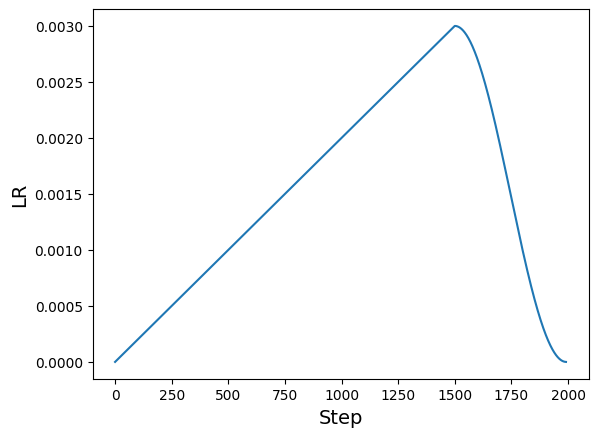

In [208]:
ARTIFICIAL_EPOCHS = 1000
ARTIFICIAL_BATCH_SIZE = 512
DATASET_NUM_TRAIN_EXAMPLES = 1020
TOTAL_STEPS = int(
    DATASET_NUM_TRAIN_EXAMPLES / ARTIFICIAL_BATCH_SIZE * ARTIFICIAL_EPOCHS
)
scheduled_lrs = WarmUpCosine(
    learning_rate_base=INIT_LR,
    total_steps=TOTAL_STEPS,
    warmup_learning_rate=0.0,
    warmup_steps=1500,
)

lrs = [scheduled_lrs(step) for step in range(TOTAL_STEPS)]
plt.plot(lrs)
plt.xlabel("Step", fontsize=14)
plt.ylabel("LR", fontsize=14)
plt.show()

In [257]:


teacher_model = model

EPOCHS = 1000
BATCH_SIZE = 32
DATASET_NUM_TRAIN_EXAMPLES = 6141
TOTAL_STEPS = int(
    DATASET_NUM_TRAIN_EXAMPLES / BATCH_SIZE * EPOCHS
)
scheduled_lrs = WarmUpCosine(
    learning_rate_base=INIT_LR,
    total_steps=TOTAL_STEPS,
    warmup_learning_rate=0.0,
    warmup_steps=1500,
)

optimizer = tf.optimizers.AdamW(
    weight_decay=WEIGHT_DECAY, learning_rate=scheduled_lrs, clipnorm=CLIP_THRESHOLD
)

student_model = get_resnetv2()

distiller = Distiller(student=student_model, teacher=teacher_model)
distiller.compile(
    optimizer,
    metrics=[keras.metrics.SparseCategoricalAccuracy()],
    distillation_loss_fn=keras.losses.KLDivergence(),
    temperature=TEMPERATURE,
)


history = distiller.fit(
    train_ds,
    steps_per_epoch=int(np.ceil(DATASET_NUM_TRAIN_EXAMPLES / BATCH_SIZE)),
    validation_data=validation_ds,
    epochs=1000,  # This should be at least 1000.
)

student = distiller.student
#student_model.compile(metrics=["accuracy"])

for metric in distiller.metrics:
    metric.reset_state()
    
_, top1_accuracy = student.evaluate(test_ds)
print(f"Top-1 accuracy on the test set: {round(top1_accuracy * 100, 2)}%")

# Final Evaluation and Display Predictions

Epoch 1/1000
Modified y shape (after one-hot encoding): (None, 4)
Modified y shape (after one-hot encoding): (None, 4)


2025-03-17 19:23:18.831618: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: INVALID_ARGUMENT: Incompatible shapes: [64,4] vs. [64]
	 [[{{function_node __inference_one_step_on_data_1402287}}{{node Equal}}]]


InvalidArgumentError: Graph execution error:

Detected at node Equal defined at (most recent call last):
  File "/opt/anaconda3/lib/python3.12/runpy.py", line 198, in _run_module_as_main

  File "/opt/anaconda3/lib/python3.12/runpy.py", line 88, in _run_code

  File "/Users/aayus/Desktop/ACM research/coding/research_venv/lib/python3.12/site-packages/ipykernel_launcher.py", line 18, in <module>

  File "/Users/aayus/Desktop/ACM research/coding/research_venv/lib/python3.12/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/Users/aayus/Desktop/ACM research/coding/research_venv/lib/python3.12/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/Users/aayus/Desktop/ACM research/coding/research_venv/lib/python3.12/site-packages/tornado/platform/asyncio.py", line 205, in start

  File "/opt/anaconda3/lib/python3.12/asyncio/base_events.py", line 641, in run_forever

  File "/opt/anaconda3/lib/python3.12/asyncio/base_events.py", line 1986, in _run_once

  File "/opt/anaconda3/lib/python3.12/asyncio/events.py", line 88, in _run

  File "/Users/aayus/Desktop/ACM research/coding/research_venv/lib/python3.12/site-packages/ipykernel/kernelbase.py", line 545, in dispatch_queue

  File "/Users/aayus/Desktop/ACM research/coding/research_venv/lib/python3.12/site-packages/ipykernel/kernelbase.py", line 534, in process_one

  File "/Users/aayus/Desktop/ACM research/coding/research_venv/lib/python3.12/site-packages/ipykernel/kernelbase.py", line 437, in dispatch_shell

  File "/Users/aayus/Desktop/ACM research/coding/research_venv/lib/python3.12/site-packages/ipykernel/ipkernel.py", line 362, in execute_request

  File "/Users/aayus/Desktop/ACM research/coding/research_venv/lib/python3.12/site-packages/ipykernel/kernelbase.py", line 778, in execute_request

  File "/Users/aayus/Desktop/ACM research/coding/research_venv/lib/python3.12/site-packages/ipykernel/ipkernel.py", line 449, in do_execute

  File "/Users/aayus/Desktop/ACM research/coding/research_venv/lib/python3.12/site-packages/ipykernel/zmqshell.py", line 549, in run_cell

  File "/Users/aayus/Desktop/ACM research/coding/research_venv/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3044, in run_cell

  File "/Users/aayus/Desktop/ACM research/coding/research_venv/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3099, in _run_cell

  File "/Users/aayus/Desktop/ACM research/coding/research_venv/lib/python3.12/site-packages/IPython/core/async_helpers.py", line 128, in _pseudo_sync_runner

  File "/Users/aayus/Desktop/ACM research/coding/research_venv/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3303, in run_cell_async

  File "/Users/aayus/Desktop/ACM research/coding/research_venv/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3486, in run_ast_nodes

  File "/Users/aayus/Desktop/ACM research/coding/research_venv/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3546, in run_code

  File "/var/folders/p0/2jw28j9n16746d30jf387ddr0000gn/T/ipykernel_12265/533318314.py", line 31, in <module>

  File "/Users/aayus/Desktop/ACM research/coding/research_venv/lib/python3.12/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/Users/aayus/Desktop/ACM research/coding/research_venv/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py", line 371, in fit

  File "/Users/aayus/Desktop/ACM research/coding/research_venv/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py", line 219, in function

  File "/Users/aayus/Desktop/ACM research/coding/research_venv/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py", line 132, in multi_step_on_iterator

  File "/Users/aayus/Desktop/ACM research/coding/research_venv/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py", line 113, in one_step_on_data

  File "/var/folders/p0/2jw28j9n16746d30jf387ddr0000gn/T/ipykernel_12265/3033878814.py", line 51, in train_step

  File "/Users/aayus/Desktop/ACM research/coding/research_venv/lib/python3.12/site-packages/keras/src/trainers/compile_utils.py", line 334, in update_state

  File "/Users/aayus/Desktop/ACM research/coding/research_venv/lib/python3.12/site-packages/keras/src/trainers/compile_utils.py", line 21, in update_state

  File "/Users/aayus/Desktop/ACM research/coding/research_venv/lib/python3.12/site-packages/keras/src/metrics/reduction_metrics.py", line 203, in update_state

  File "/Users/aayus/Desktop/ACM research/coding/research_venv/lib/python3.12/site-packages/keras/src/metrics/accuracy_metrics.py", line 240, in sparse_categorical_accuracy

  File "/Users/aayus/Desktop/ACM research/coding/research_venv/lib/python3.12/site-packages/keras/src/ops/numpy.py", line 2699, in equal

  File "/Users/aayus/Desktop/ACM research/coding/research_venv/lib/python3.12/site-packages/keras/src/backend/tensorflow/numpy.py", line 1235, in equal

Incompatible shapes: [64,4] vs. [64]
	 [[{{node Equal}}]] [Op:__inference_multi_step_on_iterator_1404075]

# Display Classification Metrics and Confusion Matrix

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def display_confusion_matrix(true_classes, predicted_classes, class_labels):
    """
    This function computes and displays a confusion matrix.
    """
    cm = confusion_matrix(true_classes, predicted_classes)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

import numpy as np

predictions = model.predict(validation_generator)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = validation_generator.classes
class_labels = list(validation_generator.class_indices.keys())

# Call the display function with correct variables
display_confusion_matrix(true_classes, predicted_classes, class_labels)


In [ ]:
def display_predictions(model, generator, num_images=20):
    """
    This function fetches a batch of images, predicts using the model,
    and displays the images with actual and predicted labels.
    """
    generator.reset()  # Resetting the generator to avoid shuffling issues
    x, y_true = next(generator)
    predictions = model.predict(x)
    predicted_classes = np.argmax(predictions, axis=1)
    true_classes = np.argmax(y_true, axis=1)
    class_labels = list(generator.class_indices.keys())

    plt.figure(figsize=(15, 10))
    for i in range(num_images):
        plt.subplot(5, 4, i + 1)  # Adjust subplot grid for the number of images
        plt.imshow(x[i])
        plt.title(f'Actual: {class_labels[true_classes[i]]}\nPredicted: {class_labels[predicted_classes[i]]}')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

display_predictions(model, validation_generator, num_images=20)